In [7]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import tensorflow as tf
from tensorflow.python.ops import control_flow_ops
import os, os.path
import sys
sys.path.insert(0,'../processing/')
sys.path.insert(0,'../')
from datasets import sythtextprovider
from nets import txtbox_300, textbox_common, np_methods
#from processing import image_processing
from image_processing2 import *
from processing import ssd_vgg_preprocessing, visualization,txt_preprocessing
import tf_utils
import time
slim = tf.contrib.slim
import load_batch
import numpy as np
import skimage.io as skio
import cv2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:
#isess = tf.InteractiveSession()

text_shape (300, 300)
0.2
file_path: ../data/sythtext/1.tfrecord


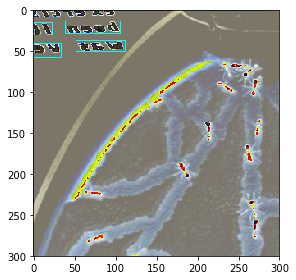

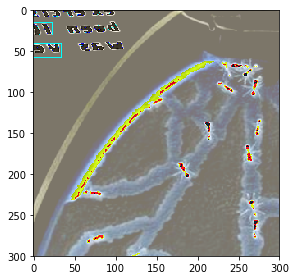

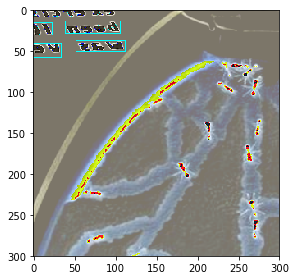

In [109]:
with tf.Graph().as_default(): 
    # build a net
    text_net = txtbox_300.TextboxNet()
    text_shape = text_net.params.img_shape
    print 'text_shape '+  str(text_shape)
    text_anchors = text_net.anchors(text_shape)
    print text_net.params.match_threshold
    
    ## dataset provider
    dataset = sythtextprovider.get_datasets('../data/sythtext/',file_pattern='1.tfrecord')
    
    data_provider = slim.dataset_data_provider.DatasetDataProvider(
            dataset, common_queue_capacity=32, common_queue_min=2)
    
    [image, shape, glabels, gbboxes,height,width] = \
    data_provider.get(['image', 'shape',
                     'object/label',
                     'object/bbox','height','width'])
    
    dst_image, glabels, gbboxes,num = \
    txt_preprocessing.preprocess_image(image,  glabels,gbboxes, 
                                            text_shape,is_training=True)

    glocalisations, gscores = \
    text_net.bboxes_encode( gbboxes, text_anchors, num)
    for i in range(6):
        glocalisations[i] = tf.expand_dims(glocalisations[i], axis=0)
        gscores[i] = tf.expand_dims(gscores[i], axis=0)
    
    with tf.Session() as sess: 
        sess.run(tf.global_variables_initializer())
        with slim.queues.QueueRunners(sess):
            for i in xrange(1):
                rpredictions, rlocalisations, img ,gbboxes_= sess.run([gscores, glocalisations,dst_image,gbboxes])
                rpredictions_2 = list(rpredictions)
                localb = []
                for i in range(6):
                    decodeb = np_methods.ssd_bboxes_decode(rlocalisations[i],text_anchors[i])
                    localb.append(decodeb[np.where(rpredictions[i] > 0.3)])
                    pre2 = np.expand_dims(1-rpredictions[i], -1)
                    rpredictions[i] = np.concatenate([pre2, np.expand_dims(rpredictions[i], -1)],axis = -1)
                rclasses, rscores, rbboxes = np_methods.ssd_bboxes_select(
                        rpredictions, rlocalisations, text_anchors,
                        select_threshold=0.001, img_shape=text_shape, num_classes=2, decode=True)

                rbboxes = np_methods.bboxes_clip(rbboxes)
                rclasses, rscores, rbboxes = np_methods.bboxes_sort(rclasses, rscores, rbboxes, top_k=-1)
                rclasses, rscores, rbboxes = np_methods.bboxes_nms(rclasses, rscores, rbboxes, 
                                                                  nms_threshold=0.45)
                #Resize bboxes to original image shape. Note: useless for Resize.WARP!
                bboxes = np.concatenate(localb, 0)
                image_ = np.uint8(img)*255
                img = image_.copy()
                visualize_bbox(img, rbboxes)
                img = image_.copy()
                visualize_bbox(img, bboxes)
                img = image_.copy()
                visualize_bbox(img, gbboxes_)

In [110]:
print rbboxes.shape
print gbboxes_.shape
#
np_methods.bboxes_clip(gbboxes_)
bboxes.shape

(4, 4)
(4, 4)


(34, 4)

In [111]:
for i in range(6):
    print rlocalisations[i][np.where(rpredictions_2[i] > 0.3)].shape

(17, 4)
(17, 4)
(0, 4)
(0, 4)
(0, 4)
(0, 4)


In [12]:
def visualize_bbox(image, bboxes):
    """
    Input: image (height, width, channels)
           bboxes (numof bboxes, 4) in order(ymin, xmin, ymax, xmax)
                  range(0,1) 
    """
    numofbox = bboxes.shape[0]
    width = image.shape[1]
    height = image.shape[0]
    def norm(x):
        if x < 0:
            x = 0
        else:
            if x > 1:
                x = 1
        return x
    xmin = [int(i * width) for i in bboxes[:,1]]
    ymin = [int(i * height) for i in bboxes[:,0]]
    ymax = [int(i * height) for i in bboxes[:,2]]
    xmax = [int(i * width) for i in bboxes[:,3]]

    for i in range(numofbox):
        image = cv2.rectangle(image,(xmin[i],ymin[i]),
                             (xmax[i],ymax[i]),(0,255,255))
    #print [ymin,xmin,ymax,xmax]
    skio.imshow(image)
    skio.show()

(38, 38, 2, 6, 4)
(38, 38, 2, 6)
[[ 3.83297205 -0.0584077   2.40580678  0.13946718]
 [ 3.07330012  1.08109939  2.40580678  0.13946718]
 [ 2.38056803  1.3956933   1.12874269  1.41653085]
 [ 3.07330012 -0.0584077   2.40580678  0.13946718]
 [ 2.38056803 -0.07540401  1.12874269  1.41653085]
 [ 2.31362987  1.08109939  2.40580678  0.13946718]
 [ 1.79212999  1.3956933   1.12874269  1.41653085]
 [ 2.31362987 -0.0584077   2.40580678  0.13946718]
 [ 1.79212999 -0.07540401  1.12874269  1.41653085]
 [ 1.55395806  1.08109939  2.40580678  0.13946718]
 [ 1.20369065  1.3956933   1.12874269  1.41653085]
 [ 1.0173043   1.65140653  0.28756186  2.25771141]
 [ 1.55395806 -0.0584077   2.40580678  0.13946718]
 [ 1.20369065 -0.07540401  1.12874269  1.41653085]
 [ 1.0173043  -0.08921923  0.28756186  2.25771141]
 [ 0.79428607  1.08109939  2.40580678  0.13946718]
 [ 0.6152513   1.3956933   1.12874269  1.41653085]
 [ 0.51998228  1.65140653  0.28756186  2.25771141]
 [ 0.79428607 -0.0584077   2.40580678  0.13946718

In [47]:
rloca

(array([], dtype=int64),
 array([], dtype=int64),
 array([], dtype=int64),
 array([], dtype=int64))